In [5]:
import datetime as dt

import pandas as pd
import polars as pl

pd.set_option("display.max_rows", 25_000)
pd.set_option("display.max_columns", 500)
pl.Config.set_tbl_cols(500)
pl.Config.set_tbl_rows(10_000)

pd.options.display.float_format = "{:.4f}".format

In [6]:
import sys

sys.path.append("..")
from tooling.enums import AssetClass, Index, Spot, StrikeSpread
from tooling.fetch import fetch_option_data, fetch_spot_data
from tooling.filter import find_atm, option_tool

In [7]:
# df.tail(25)

In [12]:
df = pd.read_csv("tradebooks/JJMS RBOS TB Combined Final 4 Indices.csv")
df['Max High'] = 0

MAX_HIGH_TIME = None

for i in range(0, len(df)):
    print(df.iloc[i]['Week'])
    contract = df.iloc[i]["Contract"]
    # print(contract)
    strike = df.iloc[i]["Strike"]
    hedge = df.iloc[i]["Hedge Strike"]
    index = (df.iloc[i]["Index"]).lower()
    call_put = df.iloc[i]["Option Type"]
    expiry = (pd.to_datetime(df.iloc[i]["Expiry"])).date()
    start_date = (pd.to_datetime(df.iloc[i]['Entry Time'])).date()
    start_time = (pd.to_datetime(df.iloc[i]['Entry Time'])).time()
    end_date = (pd.to_datetime(df.iloc[i]['Exit Time'])).date()
    end_time = (pd.to_datetime(df.iloc[i]['Exit Time'])).time()
    hedge_entry_price = df.iloc[i]['Hedge Entry Price']
    index = "bnf" if index == "banknifty" else index
    
    # print(index, expiry, strike, call_put)
    # print(type(index), type(expiry), type(strike), type(call_put))
    
    option_df = await fetch_option_data(
        index=index,
        start_date=start_date,
        start_time=start_time,
        end_date=end_date,
        end_time=end_time,
        expiry=expiry,
        strike=strike,
        asset_class=call_put[:1]
    )
    if not isinstance(option_df, str):
        if len(option_df) > 0:
            # print(option_df.head())
            option_df = option_df.to_pandas()
            max_value = option_df['h'].max()
            max_high_time = (option_df[option_df['h'] == max_value]).iloc[0]['datetime']
            df.loc[i, 'Max High'] = max_value
            df.loc[i, 'Max High Time'] = max_high_time
            MAX_HIGH_TIME = max_high_time

    hedge_df = await fetch_option_data(
        index=index,
        start_date=start_date,
        start_time=start_time,
        end_date=end_date,
        end_time=end_time,
        expiry=expiry,
        strike=hedge,
        asset_class=call_put[:1]
    )
    if not isinstance(hedge_df, str):
        if len(hedge_df) > 0:
            # print(option_df.head())
            hedge_df = hedge_df.to_pandas()
            max_value_h = hedge_df['h'].max()
            max_high_time_h = (hedge_df[hedge_df['h'] == max_value_h]).iloc[0]['datetime']
            # print(max_high_time_h)
            # print(MAX_HIGH_TIME)
            # print(hedge_df.to_string())
            # print(pd.DataFrame(hedge_df[hedge_df['datetime'] >= MAX_HIGH_TIME]).to_string())
            subset_df = hedge_df[hedge_df['datetime'] >= MAX_HIGH_TIME]
            if len(subset_df) >0:
                hedge_exit = (hedge_df[hedge_df['datetime'] >= MAX_HIGH_TIME]).iloc[0]['h']
                df.loc[i, 'Hedge Max High'] = max_value_h
                df.loc[i, 'Hedge Max High Time'] = max_high_time_h
                df.loc[i, 'Hedge at Strike Max Price'] = hedge_exit
            else:
                df.loc[i, 'Hedge Max High'] = max_value_h
                df.loc[i, 'Hedge at Strike Max Price'] = max_value_h
        else:
            df.loc[i, 'Hedge Max High'] = hedge_entry_price
            df.loc[i, 'Hedge at Strike Max Price'] = hedge_entry_price

    # break

2016-12-30


/tmp/ipykernel_4904/598888425.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '23.9' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, 'Max High'] = max_value


2016-12-30
2017-01-06
2017-01-13
2017-01-13
2017-01-13
2017-01-13
2017-01-20
2017-01-20
2017-01-27
2017-02-03
2017-02-10
2017-02-10
2017-02-10
2017-02-17
2017-02-17
2017-02-24
2017-02-24
2017-03-03
2017-03-03
2017-03-03
2017-03-10
2017-03-10
2017-03-17
2017-03-17
2017-03-24
2017-03-31
2017-03-31
2017-04-07
2017-04-07
2017-04-07
2017-04-07
2017-04-14
2017-04-14
2017-04-14
2017-04-28
2017-04-28
2017-04-28
2017-05-05
2017-05-05
2017-05-12
2017-05-12
2017-05-12
2017-05-19
2017-05-26
2017-06-02
2017-06-02
2017-06-02
2017-06-09
2017-06-09
2017-06-16
2017-06-16
2017-06-23
2017-06-23
2017-06-30
2017-06-30
2017-07-07
2017-07-14
2017-07-14
2017-07-14
2017-07-21
2017-07-28
2017-07-28
2017-07-28
2017-07-28
2017-08-04
2017-08-04
2017-08-11
2017-08-18
2017-08-25
2017-08-25
2017-09-01
2017-09-01
2017-09-08
2017-09-15
2017-09-15
2017-09-29
2017-09-29
2017-10-06
2017-10-06
2017-10-06
2017-10-13
2017-10-13
2017-10-20
2017-10-27
2017-10-27
2017-11-03
2017-11-03
2017-11-10
2017-11-17
2017-11-17
2017-11-17

In [13]:
df['Portfolio'] = 1000000
df['Strat Entry'] = df['Entry Price']
df['High Entry Ratio'] = df.apply(lambda row: (row['Max High'] / row['Strat Entry']), axis=1)
df['Sell Strike Max MTM Loss'] = df.apply(lambda row: ((row['Strat Entry'] - row['Max High']) * row['Qty']), axis=1)
df['Sell Strike Max MTM Loss Pct'] = df.apply(lambda row: ((row['Sell Strike Max MTM Loss'] / row['Portfolio']) * 100), axis=1)
df['Max MTM Loss'] = df.apply(lambda row: (((row['Strat Entry'] - row['Max High']) * row['Qty']) + ((row['Hedge at Strike Max Price'] - row['Hedge Entry Price']) * row['Qty'])), axis=1)
df['Max MTM Loss Pct'] = df.apply(lambda row: ((row['Max MTM Loss']/row['Portfolio'])*100), axis=1)

In [14]:
df

Unnamed: 0        Week  Week High   Week Low  Weekly Range  \
0             0  2016-12-30 18248.2000 17831.7500      416.4500   
1           315  2016-12-30  8282.5500  8134.3000      148.2500   
2           316  2017-01-06  8417.0000  8228.0000      189.0000   
3           318  2017-01-13  8460.2000  8373.1500       87.0500   
4             2  2017-01-13 19276.2500 18781.6000      494.6500   
5           317  2017-01-13  8460.2000  8373.1500       87.0500   
6             1  2017-01-13 19276.2500 18781.6000      494.6500   
7             3  2017-01-20 19517.7000 18725.0500      792.6500   
8           319  2017-01-20  8612.1500  8328.0500      284.1000   
9             4  2017-01-27 20145.9000 19435.7500      710.1500   
10          320  2017-02-03  8821.2000  8707.7500      113.4500   
11          322  2017-02-10  8826.4500  8713.0500      113.4000   
12            5  2017-02-10 20366.7000 20088.4000      278.3000   
13          321  2017-02-10  8826.4500  8713.0500      113.4000   
14            6  2017-02-17 21031.6500 20452.6000      579.0500   
15          323  2017-02-17  8981.9000  8804.7500      177.1500   
16          324  2017-02-24  8992.3500  8868.1000      124.2500   
17            7  2017-02-24 20901.0000 20518.5000      382.5000   
18          326  2017-03-03  8977.7500  8860.3000      117.4500   
19          325  2017-03-03  8977.7500  8860.3000      117.4500   
20            8  2017-03-03 20777.1500 20423.7000      353.4500   
21          327  2017-03-10  9158.1000  8904.1000      254.0000   
22            9  2017-03-10 21289.3000 20653.5000      635.8000   
23          328  2017-03-17  9214.1000  9019.4000      194.7000   
24           10  2017-03-17 21316.8500 20755.1500      561.7000   
25          329  2017-03-24  9181.1000  9024.6500      156.4500   
26          330  2017-03-31  9273.8000  9152.1500      121.6500   
27           11  2017-03-31 21699.0000 21408.6000      290.4000   
28          331  2017-04-07  9250.4500  9145.0000      105.4500   
29           12  2017-04-07 21786.9500 21396.7000      390.2500   
30          332  2017-04-07  9250.4500  9145.0000      105.4500   
31           13  2017-04-07 21786.9500 21396.7000      390.2500   
32          334  2017-04-14  9217.8000  9075.3000      142.5000   
33           14  2017-04-14 21947.0000 21417.2000      529.8000   
34          333  2017-04-14  9217.8000  9075.3000      142.5000   
35          336  2017-04-28  9365.5000  9270.0000       95.5000   
36           15  2017-04-28 22740.8500 22185.2500      555.6000   
37          335  2017-04-28  9365.5000  9270.0000       95.5000   
38           16  2017-05-05 22977.2000 22515.3500      461.8500   
39          337  2017-05-05  9450.3000  9272.0500      178.2500   
40          338  2017-05-12  9532.2000  9372.6000      159.6000   
41           18  2017-05-12 22977.6500 22579.3500      398.3000   
42           17  2017-05-12 22977.6500 22579.3500      398.3000   
43          339  2017-05-19  9522.7000  9341.9000      180.8000   
44           19  2017-05-26 23469.4500 23095.0000      374.4500   
45           20  2017-06-02 23653.3500 23309.0500      344.3000   
46          340  2017-06-02  9706.3000  9630.5000       75.8000   
47          341  2017-06-02  9706.3000  9630.5000       75.8000   
48           21  2017-06-09 23706.6500 23311.9000      394.7500   
49          342  2017-06-09  9676.0000  9560.8000      115.2000   
50          343  2017-06-16  9698.6000  9565.7000      132.9000   
51           22  2017-06-16 23896.9000 23391.0000      505.9000   
52          344  2017-06-23  9646.6500  9473.7000      172.9500   
53           23  2017-06-23 23778.4000 23056.4000      722.0000   
54           24  2017-06-30 23540.1500 22998.0500      542.1000   
55          345  2017-06-30  9700.6000  9448.8000      251.8000   
56           25  2017-07-07 23960.3000 23401.8000      558.5000   
57          347  2017-07-14  9928.2000  9813.8000      114.4000   
58          346  2017-07-14  9928.2000  9813.8000   

In [30]:
# df['Max MTM Loss Pct'].min()
df.loc[df['Sell Strike Max MTM Loss Pct'] > 0]

Unnamed: 0        Week  Week High   Week Low  Weekly Range  \
312         480  2020-03-06 11034.5000  9508.4000     1526.1000   
313         146  2020-03-06 28042.5000 23613.1000     4429.4000   

     Current Week Open Multiplier to Range  Entry Level Long  \
312          9107.6000                 40%         9718.0400   
313         22720.7500                 50%        24935.4500   

     Entry Level Short Break Type  Strike      Expiry  DTE  \
312          8497.1600       high    8500  2020-03-19    6   
313         20506.0500       high   20500  2020-03-19    6   

                  Contract Option Type           Entry Time  Entry Price  \
312       NIFTY203198500PE          PE  2020-03-13 10:52:00     150.0000   
313  BANKNIFTY2031920500PE          PE  2020-03-13 12:37:00     297.0500   

               Exit Time  Exit Price  Remark  Points  Slippage  Points w cs  \
312  2020-03-13 10:56:00     75.2500  SL Hit 74.7500    2.2525      72.4975   
313  2020-03-16 09:24:00    297.0500  SL Hit  0.0000    5.9410      -5.9410   

          Qty         PnL    PnL w cs    ROI%  ROI% w cs  Trade Year  \
312 1764.7059 131911.7647 127936.7647 13.1912    12.7937        2020   
313  426.8293      0.0000  -2535.7927  0.0000    -0.2536        2020   

     Hedge Strike         Hedge Contract  Hedge Entry Price  Hedge Exit Price  \
312          8350       NIFTY203198350PE             0.0000            0.0000   
313         19900  BANKNIFTY2031919900PE             0.0000            0.0000   

     Hedge Points  Hedge PnL   Total PnL  Total ROI%      Index  Trade Month  \
312        0.0000     0.0000 127936.7647     12.7937      NIFTY            3   
313        0.0000     0.0000  -2535.7927     -0.2536  BANKNIFTY            3   

     Cumulative ROI%  Running Max ROI%  Drawdown  Max High Max High Time  \
312         127.9889          127.9889    0.0000    0.0000           NaT   
313         127.7353          127.9889   -0.2536    0.0000           NaT   

     Hedge Max High Hedge Max High Time  Hedge at Strike Max Price  Portfolio  \
312             NaN                 NaT                        NaN    1000000   
313             NaN                 NaT                        NaN    1000000   

     Strat Entry  High Entry Ratio  Sell Strike Max MTM Loss  \
312     150.0000            0.0000               264705.8824   
313     297.0500            0.0000               126789.6341   

     Sell Strike Max MTM Loss Pct  Max MTM Loss  Max MTM Loss Pct  
312                       26.4706           NaN               NaN  
313                       12.6790           NaN               NaN

In [20]:
df.to_csv('Check RBOS JJMS 2.csv')

In [21]:
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

percentile_values = df['High Entry Ratio'].quantile(percentiles)

print("Percentile Distribution of 'High Entry Ratio':")
print(percentile_values)

Percentile Distribution of 'High Entry Ratio':
0.1000   1.0471
0.2500   1.1109
0.5000   1.3181
0.7500   1.9884
0.9000   2.9723
0.9500   4.3523
0.9900   6.4218
Name: High Entry Ratio, dtype: float64


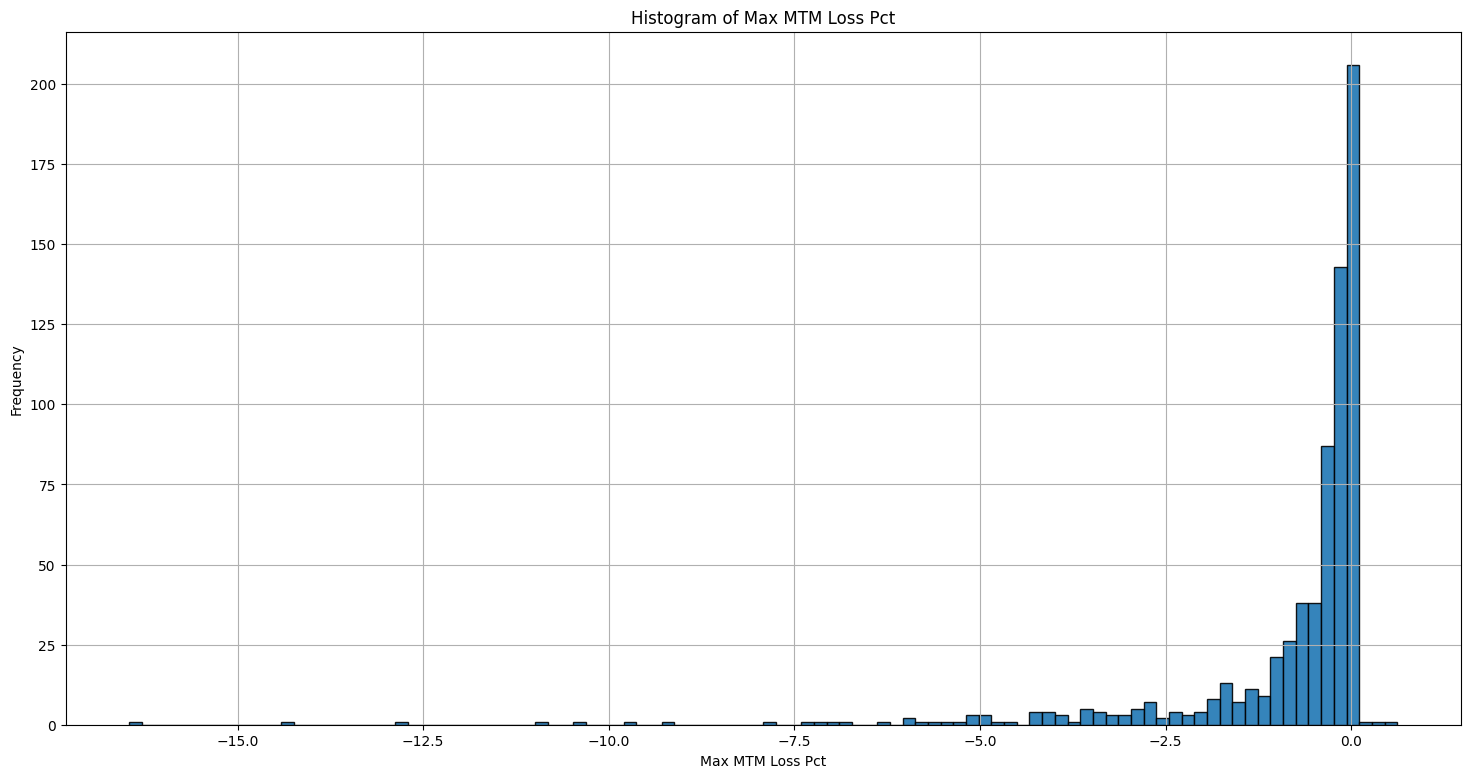

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Plotting the histogram
plt.figure(figsize=(18, 9))
plt.hist(df['Max MTM Loss Pct'], bins=100, edgecolor='k', alpha=0.9)
plt.title('Histogram of Max MTM Loss Pct')
plt.xlabel('Max MTM Loss Pct')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


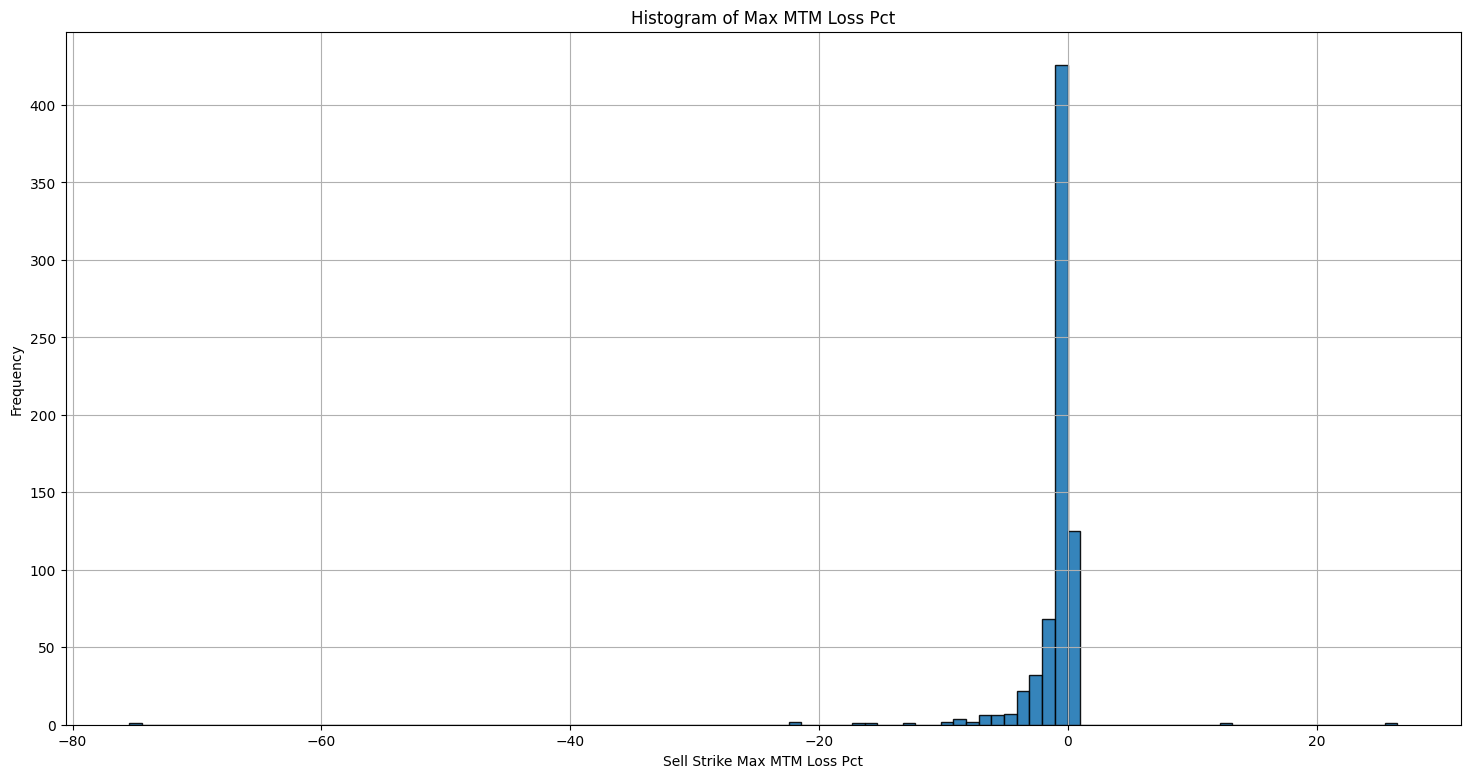

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Plotting the histogram
plt.figure(figsize=(18, 9))
plt.hist(df['Sell Strike Max MTM Loss Pct'], bins=100, edgecolor='k', alpha=0.9)
plt.title('Histogram of Max MTM Loss Pct')
plt.xlabel('Sell Strike Max MTM Loss Pct')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [33]:
import pandas as pd

df2 = df.copy()
sorted_df = df2.sort_values(by='Sell Strike Max MTM Loss Pct', ascending=True)

# To sort in descending order, set ascending=False

# Display the sorted DataFrame
sorted_df

Unnamed: 0        Week  Week High   Week Low  Weekly Range  \
311         481  2020-03-06 11034.5000  9508.4000     1526.1000   
359         505  2020-08-21 11616.5000 11362.4000      254.1000   
327         488  2020-05-01  9533.5000  9117.3500      416.1500   
419         540  2021-05-07 14966.8000 14650.1000      316.7000   
342         496  2020-07-03 10847.7000 10563.0500      284.6500   
328         487  2020-05-01  9533.5000  9117.3500      416.1500   
296         472  2020-01-10 12389.0000 12213.6000      175.4000   
326         154  2020-05-01 20514.7500 18943.9500     1570.8000   
358         168  2020-08-21 23700.7000 22169.5500     1531.1500   
501         582  2022-02-25 16814.7500 16356.5500      458.2000   
800         712  2024-01-30 10822.3000 10542.7000      279.6000   
215         430  2019-02-15 10808.8000 10585.9000      222.9000   
638         770  2023-02-08 18619.5000 18343.3000      276.2000   
262         455  2019-09-06 11081.7500 10867.6500      214.1000   
390         522  2020-12-25 14024.4000 13812.0000      212.4000   
196          91  2018-11-30 27032.9000 26150.6000      882.3000   
403         530  2021-02-19 15173.7500 14636.1000      537.6500   
254         451  2019-08-09 11181.3000 10904.8000      276.5000   
307         144  2020-02-21 30702.1500 29918.8500      783.3000   
362         507  2020-09-04 11463.0500 11185.3000      277.7500   
429         544  2021-06-04 15800.4500 15567.7000      232.7500   
784         682  2024-01-05 21763.9500 21448.6500      315.3000   
183          85  2018-10-19 25491.4500 24699.8500      791.6000   
232         107  2019-04-26 30047.3000 29550.8500      496.4500   
680         786  2023-05-17 19485.0500 19206.8000      278.2500   
279         465  2019-11-15 12038.5000 11867.8000      170.7000   
813         824  2024-02-21 20897.3000 20440.9000      456.4000   
547         600  2022-06-24 15926.5000 15619.8000      306.7000   
177          81  2018-09-28 25464.0000 24503.2500      960.7500   
785         304  2024-01-05 48381.9500 47010.8000     1371.1500   
272         461  2019-10-18 11713.8000 11535.9500      177.8500   
430         547  2021-06-11 15901.2000 15607.7500      293.4500   
474         219  2021-11-26 36860.8500 35341.7500     1519.1000   
576         609  2022-09-02 17806.9500 17477.1000      329.8500   
630         264  2023-01-13 42712.3000 41863.0000      849.3000   
766         677  2023-12-08 21210.9000 20769.5000      441.4000   
181          83  2018-10-12 25903.1500 25001.9500      901.2000   
431         200  2021-06-11 35377.7000 34382.9000      994.8000   
257         452  2019-08-16 11146.8000 10718.9500      427.8500   
668         782  2023-04-26 19264.2000 18861.3500      402.8500   
625         630  2022-12-30 18264.6000 17892.6000      372.0000   
402         188  2021-02-12 37703.0500 35702.1000     2000.9500   
588         616  2022-10-07 17336.9500 16950.6500      386.3000   
509         585  2022-03-18 17441.7000 17006.4000      435.3000   
308         478  2020-02-21 12012.5500 11536.9500      475.6000   
466         566  2021-11-05 18112.1000 17799.5000      312.6000   
147         396  2018-06-15 10833.9000 10701.5500      132.3500   
587         755  2022-10-05 17896.7000 17411.7000      485.0000   
776         814  2023-12-27 21627.3500 21299.1000      328.2500   
320         484  2020-04-10  9260.5500  8823.2000      437.3500   
187          87  2018-11-02 25857.6000 25500.4500      357.1500   
679         785  2023-05-17 19485.0500 19206.8000      278.2500   
460         212  2021-10-15 40199.4500 39300.1500      899.3000   
29           12  2017-04-07 21786.9500 21396.7000      390.2500   
798         686  2024-01-26 21832.9500 21429.6000      403.3500   
619         628  2022-12-16 18472.5000 18068.9500      403.5500   
236         441  2019-05-10 11345.4500 11108.4500      237.0000   
404         189  2021-02-19 37220.7000 34986.5000     2234.2000   
517         588  2022-04-08 17842.4000 17443.1000   